In [12]:
%matplotlib inline
from modsim import *


earth = Condition(thickness = 14140,
                     surface_area = 5.099686589e+14,
                     density = 5510)
earth.radius = sqrt(earth.surface_area / (8 * np.pi))
earth.volume1 = earth.thickness * earth.radius** 2 * np.pi
earth.mass = earth.volume1 * earth.density
print(earth.radius)



baseball = Condition(x = earth.radius / 2.5, 
                      y = (earth.thickness/2) + 1,
                      ay = 9.8,
                      G = 6.67e-11,
                      mass = 145e-3,
                      diameter = 73e-4,
                      rho = 1,
                      C_d = 0.3,
                      angle = 60,
                      velocity = 5,
                      duration =1000)

def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 1001)
    
    return System(init=init, G=G, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

def slope_func(state, t, system):
    x, y, vx, vy = state
    unpack(system)
    
    p = Vector(x, y)
    v = Vector(vx, vy)
    
    
    
    
    #f_grav = p.hat() * (-G * earth.mass/3 * mass / (p.mag**2))
    
    
    
    #n input is always a radix, total nodes = 2n+1 (1=>3 2=>5)
    n = 50
    f_add = 0
    
    for i in range(n):
        dtl = Vector(x+earth.radius*(i/n),y)
        dtr = Vector(earth.radius*(i/n)-x,y)
        f_grav_l = dtl.hat() * (-G * earth.mass/n * mass / (dtl.mag**2))
        f_grav_r = dtr.hat() * (-G * earth.mass/n * mass / (dtr.mag**2))
        f_add = f_grav_r + f_grav_l
    
    #f_grav is accounted in each radix traversal, renormalize c_g
    f_grav_tot = f_add
    
    f_drag = -rho * v.mag * v * C_d * area / 2
    
    if y > (earth.thickness / 2):
        a_grav = f_grav_tot / mass
        a_y= Vector(0, -ay)
        a_drag = f_drag / mass
    else:
        a_grav = Vector(0, 0)
        a_y = Vector(0, 0)
        a_drag = Vector(0, 0)
    
    a = a_grav + a_y
    a = a_grav + a_drag + a_y

    return vx, vy, a.x, a.y

def find_landing(system):
    counter = 0
    for height in system.results.y:
        if (height < (earth.thickness / 2)):
            #print(system.results.y.index[counter])
            return system.results.y.index[counter]
        counter += 1
        
def interpolate_range(results):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = results.x
    ys = results.y
    t_end = ys.index[-1]
    
    if ys[t_end] > (earth.thickness / 2):
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    t_land = T(earth.thickness / 2)
    X = interpolate(xs, kind='cubic')
    return X(t_land)

def interpolate_time(results):
    """Computes the range of the ball when it lands.
    
    results: TimeFrame with x and y
    
    returns: distance in meters
    """
    xs = results.x
    ys = results.y
    t_end = ys.index[-1]
    
    if ys[t_end] > (earth.thickness / 2):
        msg = """The final value of y is still positive;
                 looks like the simulation didn't run
                 long enough."""
        raise ValueError(msg)
        
    t_peak = ys.argmax()
    descent = ys.loc[t_peak:]
    T = interp_inverse(descent, kind='cubic')
    
    return T(0)

def calc_dist(system):
    range_int = interpolate_range(system.results)
    dist = abs(system.init.x - range_int)
    return dist



4504554.16456


In [13]:
system = make_system(baseball)
system.init

,value
x,1.801822e+06
y,7.071000e+03
vx,2.500000e+00
vy,4.330127e+00


In [14]:
system = make_system(baseball)
run_odeint(system, slope_func)
find_landing(system)

2.0

dist is 3.9689311629
dist is 3.96886191797
dist is 3.96860696701
dist is 3.96793944621
dist is 3.96582405921


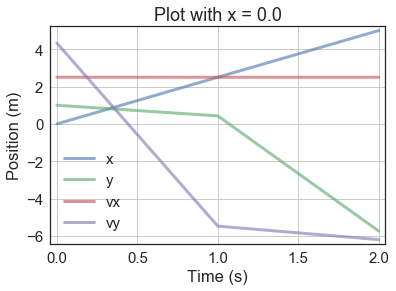

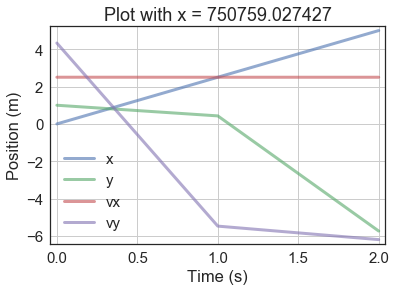

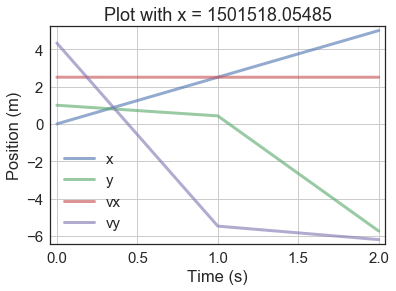

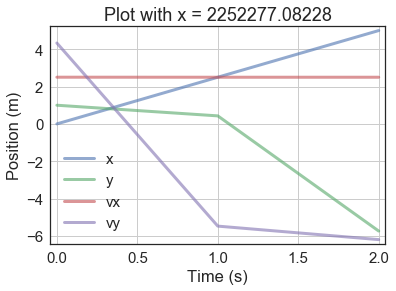

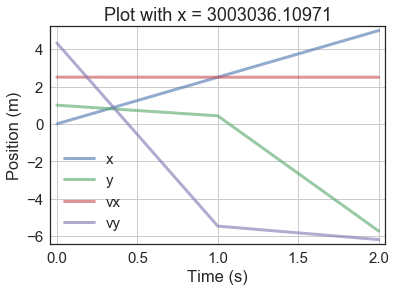

In [15]:
for x in linspace(0, earth.radius/1.5, 5):
    
    baseball.x = x
    system = make_system(baseball)
    slope_func(system.init, 0, system)


    run_odeint(system, slope_func)

    xs = system.results.x  - (x)
    ys = system.results.y - (earth.thickness / 2)

    xv = system.results.vx
    yv = system.results.vy

    ground_time = find_landing(system)

    newfig()
    plot(xs[:ground_time], label='x')
    plot(ys[:ground_time], label='y')
    plot(xv[:ground_time], label='vx')
    plot(yv[:ground_time], label='vy')
    plt.grid()
    decorate(title='Plot with x = ' + str(x),
                xlabel='Time (s)',
             ylabel='Position (m)',)
    print("dist is " + str(calc_dist(system)))



dist is 3.96892432123


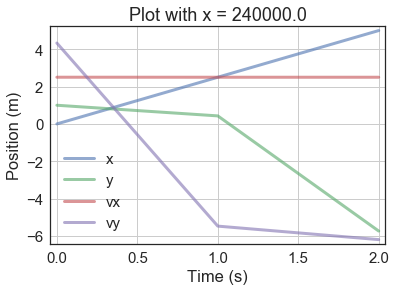

In [16]:
baseball.x = 240000
system = make_system(baseball)
slope_func(system.init, 0, system)


run_odeint(system, slope_func)

xs = system.results.x  - (x)
ys = system.results.y - (earth.thickness / 2)

xv = system.results.vx
yv = system.results.vy

ground_time = find_landing(system)

newfig()

plot(xs[:ground_time], label='x')
plot(ys[:ground_time], label='y')
plot(xv[:ground_time], label='vx')
plot(yv[:ground_time], label='vy')

plt.grid()
decorate(title='Plot with x = ' + str(x),
            xlabel='Time (s)',
         ylabel='Position (m)',)
print("dist is " + str(calc_dist(system)))

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


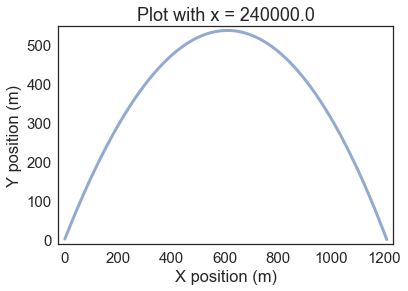

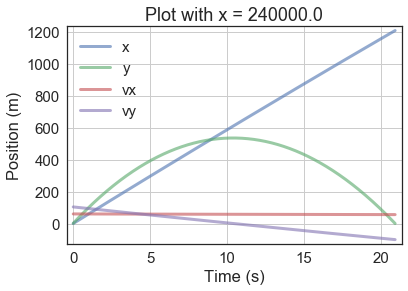

In [17]:
baseball.x = 240000
baseball.angle = 60
baseball.duration = 30
baseball.velocity = 120

system = make_system(baseball)

slope_func(system.init, 0, system)


run_odeint(system, slope_func)
xs = system.results.x  - (x)
ys = system.results.y - (earth.thickness / 2)

xv = system.results.vx
yv = system.results.vy

ground_time = find_landing(system)
xx = xs[:ground_time]
yy = ys[:ground_time]
newfig()

plot(xx, yy)
decorate(title='Plot with x = ' + str(x),
            xlabel='X position (m)',
         ylabel='Y position (m)',)    

newfig()
plot(xs[:ground_time], label='x')
plot(ys[:ground_time], label='y')
plot(xv[:ground_time], label='vx')
plot(yv[:ground_time], label='vy')

plt.grid()
decorate(title='Plot with x = ' + str(x),
            xlabel='Time (s)',
         ylabel='Position (m)',)

In [ ]:
for i in range(1):
    newfig()
    for x in linspace(0, 500000, 200):
        baseball.x = x

        system = make_system(baseball)
        
        run_odeint(system, slope_func)
        plt.grid()
        #print(system.results.y[300])
        #print(system.results)
        plot(x, (interpolate_range(system.results) - system.init.x), 'b-')
        decorate(xlabel='initial distance from pole',
                 ylabel='final distance to initial')
       


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [ ]:
for x in linspace(0, 500000, 500):
    baseball.x = x
    system = make_system(baseball)

    run_odeint(system, slope_func)
    plt.grid()
    #print(system.results.y[300])
    #print(system.results)
    plot(x, interpolate_time(system.results), 'b-')
    decorate(xlabel='initial distance from pole',
             ylabel='time for simulation')

In [ ]:
for velocity in linspace(0, 500, 100):
    baseball.velocity = velocity
    system = make_system(baseball)

    run_odeint(system, slope_func)
    plt.grid()
    #print(system.results.y[300])
    #print(system.results)
    plot(velocity, (interpolate_range(system.results)) - system.init.x, 'b-')
    decorate(xlabel='initial velocity',
            ylabel='final distance to initial')

In [ ]:
newfig()
plt.grid()
colors = ['black', 'blue', 'red', 'green', 'yellow', 'cyan', 'orange', 'purple', 'grey', 'pink', 'olive', 'navy']
counter = 0
for theta in linspace(10, 90, 9):
    baseball.angle = theta
    print(baseball.angle)
    for x in linspace(0, 500000, 50):
        baseball.x = x
        #print(baseball.x)
        system = make_system(baseball)
        
        run_odeint(system, slope_func)
        
        #print(system.results.y[300])
        #print(system.results)
        plot(x, (interpolate_range(system.results) - system.init.x), 'o', color = colors[counter % 12], label = '%s degrees' %theta)
        decorate(xlabel='initial distance from pole (m)',
                 ylabel='final distance to initial (m)',
                 title = 'Distance between throwing and landing location')
    counter += 1

In [ ]:
import colorsys
colorsys.rgb_to_hsv(0.1, 0.5, 0.3)
distances = np.zeros(15)

counter = 0

for x in linspace(0, 500000, 25):
    baseball.x = x
    newfig()
    plt.grid()
    for theta in linspace(10, 90, 9):
        baseball.angle = theta
        #print(baseball.angle)
        for velocity in linspace(10, 750, 75):
            baseball.velocity = velocity

            system = make_system(baseball)

            run_odeint(system, slope_func)
            distance = abs(interpolate_range(system.results) - system.init.x)
            if distance > distances[counter]:
                distances[counter] = distance
            color_rgb = colorsys.hsv_to_rgb((distance / 80000), 1, 1)
            plot(velocity, theta, 'o', color = color_rgb)
            decorate(xlabel='initial velocity (m/s)',
                     ylabel='initial angle (deg)',
                     title = 'Distance between throwing and landing location at x = %s meters' %x)
    counter += 1
    
distances

In [ ]:
import colorsys
newfig()
plt.grid()
colors = ['black', 'blue', 'red', 'green', 'yellow', 'cyan', 'orange', 'purple', 'grey', 'pink', 'olive', 'navy']
counter = 0
for theta in linspace(10, 90, 9):
    baseball.angle = theta
    print(baseball.angle)
    for x in linspace(0, 500000, 50):
        baseball.x = x
        
        system = make_system(baseball)
        
        run_odeint(system, slope_func)
        
        #print(system.results.y[300])
        #print(system.results)
        color_rgb = colorsys.hsv_to_rgb((abs(interpolate_range(system.results) - system.init.x) / 6600), 1, 1)
        plot(x, (interpolate_range(system.results) - system.init.x), 'o', color = color_rgb)
        decorate(xlabel='initial distance from pole (m)',
                 ylabel='final distance to initial (m)',
                 title = 'Distance between throwing and landing location')
    counter += 1

In [ ]:
distances